<a href="https://colab.research.google.com/github/jenriver/bonsai/blob/main/SAM2_image_predictor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suggested runtime: TPU v2-8

# **Object masks in images from prompts with SAM 2**

Segment Anything Model 2 (SAM 2) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

*This colab is modified from the original [SAM2 colab](https://github.com/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb).*

## **Set-up**

In [1]:
!pip install -q git+https://github.com/jax-ml/bonsai
!pip install -q opencv-python

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import sys

from huggingface_hub import snapshot_download
import jax
from jax.lib import xla_bridge
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
!wget -q -P ./images/ truck.jpg "https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg"
!wget -q -P ./images/ cars.jpg "https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg"
!wget -q -P ./images/ groceries.jpg "https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg"

' '.join(os.listdir("./images"))

'truck.jpg.2 cars.jpg.3 groceries.jpg.4 truck.jpg.1 groceries.jpg.1 truck.jpg cars.jpg.5 truck.jpg.4 truck.jpg.3 groceries.jpg.2 groceries.jpg.3 groceries.jpg.5 cars.jpg.2 cars.jpg cars.jpg.4 truck.jpg.5 cars.jpg.1 groceries.jpg'

In [4]:
key = jax.random.PRNGKey(3)

def show_mask(mask, ax, *, random_color=False, borders=True):
    if random_color:
        rgb = jax.random.uniform(key, (3,))
        color = jnp.concatenate([rgb, jnp.array([0.6])])
    else:
        color = jnp.array([30/255, 144/255, 1.0, 0.6])
    h, w = mask.shape[-2:]
    mask_uint8 = jax.device_get(mask.astype(jnp.uint8))  # JAX → np broadcast
    mask_img = mask_uint8.reshape(h, w, 1) * color.reshape(1, 1, -1)

    if borders:
        import cv2
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(c, epsilon=0.01, closed=True) for c in contours]
        mask_img = cv2.drawContours(mask_img.copy(), contours, -1, color=(1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_img)

def show_points(coords, labels, ax, marker_size=375):
    coords, labels = jax.device_get(coords), jax.device_get(labels)
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = float(box[0]), float(box[1])
    w, h = float(box[2] - box[0]), float(box[3] - box[1])
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(jax.device_get(image))
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None, "Need labels for each point"
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [5]:
image = Image.open('images/truck.jpg')
image = np.array(image.convert("RGB"))

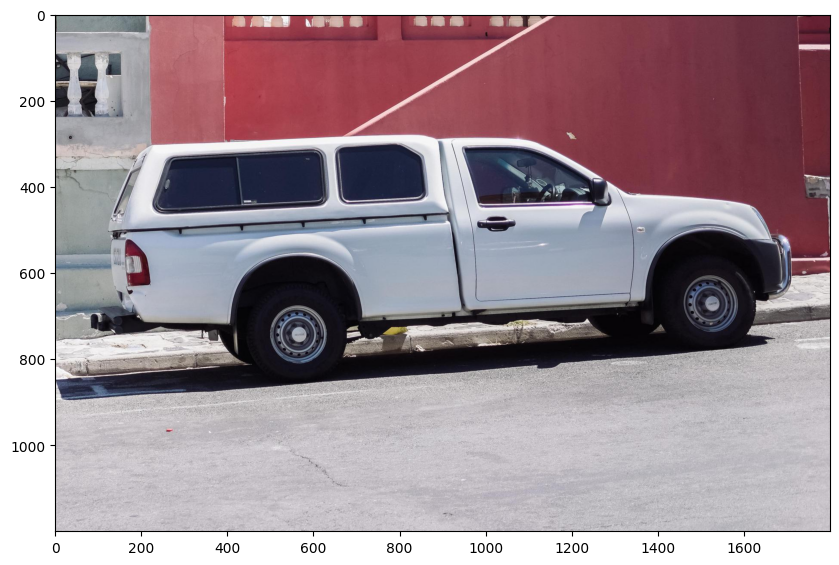

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## **Selecting objects with SAM 2**

In [7]:
from bonsai.models.sam2 import modeling, params

model_name = "facebook/sam2-hiera-small-hf"
MODEL_CP_PATH = "./checkpoints/" + model_name.split("/")[1]
snapshot_download(model_name, local_dir=MODEL_CP_PATH)

config = modeling.SAM2Config.sam2_small()
model_obj = params.create_sam2_from_pretrained(MODEL_CP_PATH + '/model.safetensors', config)

predictor = modeling.SAM2ImagePredictor(model_obj)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
batch_size = 3
batched_images = [image for _ in range(batch_size)]
predictor.set_image_batch(batched_images)

In [9]:
batched_points = [jnp.array([[500, 375]]) for _ in range(batch_size)]
batched_labels = [jnp.array([1.0]) for _ in range(batch_size)]

In [10]:
masks, ious, lowres = modeling.forward(predictor, batched_points, batched_labels)
jax.block_until_ready(masks)

[Array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

In [11]:
print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(1200, 1800, 3)


In [12]:
print(type(masks[0]))
print(masks[0].shape)

<class 'jaxlib.xla_extension.ArrayImpl'>
(3, 1200, 1800)


mask 0 shape before reshape: (3, 1200, 1800)
score 0 shape: (3,)


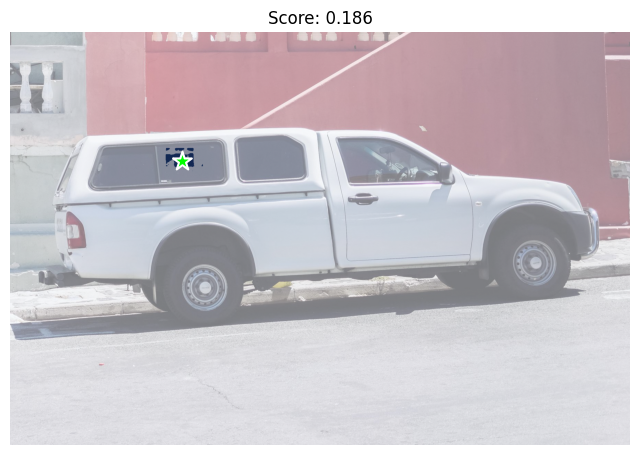

mask 1 shape before reshape: (3, 1200, 1800)
score 1 shape: (3,)


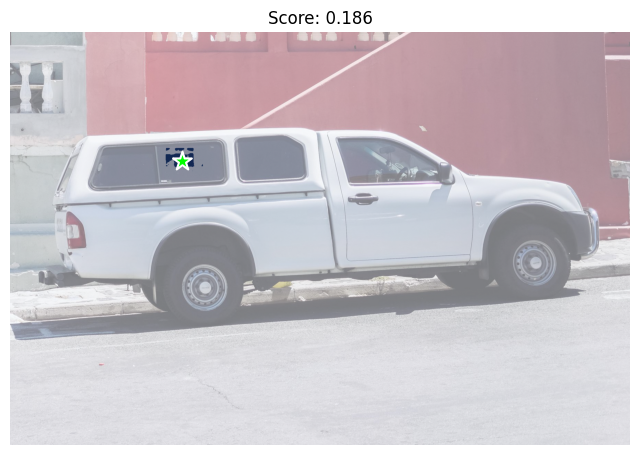

mask 2 shape before reshape: (3, 1200, 1800)
score 2 shape: (3,)


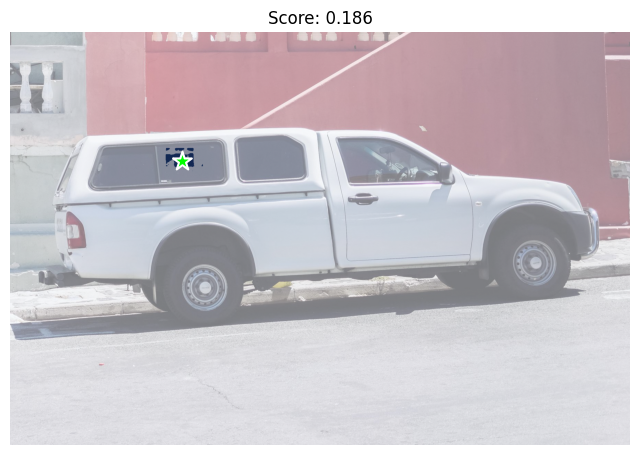

In [13]:
for i in range(len(masks)):
    mask = masks[i]
    score = ious[i]
    print(f"mask {i} shape before reshape:", mask.shape)
    print(f"score {i} shape:", score.shape)
    # Convert (3, 256, 256) to (256, 256)
    if mask.shape[0] == 3:
        mask = mask[0]  # or mask = mask.mean(axis=0) for average
    # Use only the first score value
    score_scalar = float(score[0]) if hasattr(score, "__getitem__") else float(score)
    plt.figure(figsize=(8, 8))
    plt.imshow(jax.device_get(batched_images[i]))
    plt.imshow(jax.device_get(mask), alpha=0.5, cmap='Blues')
    plt.scatter(
        jax.device_get(batched_points[i])[:, 0],
        jax.device_get(batched_points[i])[:, 1],
        c=['lime' if l == 1 else 'red' for l in jax.device_get(batched_labels[i])],
        s=200, marker='*', edgecolors='white', linewidths=1.5
    )
    plt.title(f"Score: {score_scalar:.3f}")
    plt.axis('off')
    plt.show()